In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from pycm import *
from PIL import Image, ImageFile
import seaborn as sns
import torch
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

In [5]:
DATA_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/'
TRAIN_DIR = DATA_DIR + 'Final_Images/train_img_final/'
TEST_DIR = DATA_DIR + 'Final_Images/test_img_final/'

# load train images annotations
train_info = json.load(open(DATA_DIR + 'iwildcam2020_train_annotations.json'))
# split json into several pandas dataframes
train_annotations = pd.DataFrame(train_info['annotations'])
train_images = pd.DataFrame(train_info['images'])
train_categories = pd.DataFrame(train_info['categories'])

# load test images info
test_info = json.load(open(DATA_DIR + 'iwildcam2020_test_information.json'))
# split json into several pandas dataframes
test_images = pd.DataFrame(test_info['images'])
test_categories = pd.DataFrame(test_info['categories'])

# Load Location info
loc_info = pd.read_csv('multispec_avg.csv')
loc_info['loc'] = loc_info['loc'].astype(int)

In [6]:
df_train = pd.merge(train_annotations, train_images, how='outer', left_on='image_id', right_on='id')
df_train = df_train.drop(['id_y'], axis=1)

df_train['Date'] = pd.to_datetime(df_train['datetime']).dt.date
df_train = df_train.astype({'Date': str})
df_train['Time'] = pd.to_datetime(df_train['datetime']).dt.time
df_train = df_train.astype({'Time': str})

df_train['Year'] = df_train['Date'].str.slice(0, 4, 1)
df_train = df_train.astype({'Year': int})
df_train['Month'] = df_train['Date'].str.slice(5, 7, 1)
df_train = df_train.astype({'Month': int})
df_train['Day'] = df_train['Date'].str.slice(8, 10, 1)
df_train = df_train.astype({'Day': int})

df_train['Hour'] = df_train['Time'].str.slice(0, 2, 1)
df_train = df_train.astype({'Hour': int})
df_train['Min'] = df_train['Time'].str.slice(3, 5, 1)
df_train = df_train.astype({'Min': int})
df_train['Sec'] = df_train['Time'].str.slice(6, 8, 1)
df_train = df_train.astype({'Sec': int})

df_train = df_train.drop(['Date', 'Time'], axis=1)

df_train.columns = ['animal_cnt', 'image_id', 'id', 'category_id', 'seq_num_frames', 'location', 'datetime', 'frame_num', 'seq_id', 'width', 'height', 'file_name', 'year',
                    'month', 'day', 'hour', 'min', 'sec']

df_train = df_train[['id', 'seq_id', 'image_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'animal_cnt', 'year',
                     'month', 'day', 'hour', 'min', 'sec', 'category_id']]

df_train['category_id'] = df_train['category_id'].apply(str)

In [7]:
corrupted_files = ['87022118-21bc-11ea-a13a-137349068a90.jpg',
                   '8f17b296-21bc-11ea-a13a-137349068a90.jpg',
                   '883572ba-21bc-11ea-a13a-137349068a90.jpg',
                   '896c1198-21bc-11ea-a13a-137349068a90.jpg',
                   '8792549a-21bc-11ea-a13a-137349068a90.jpg',
                   '99136aa6-21bc-11ea-a13a-137349068a90.jpg']

for corrupted_file in corrupted_files:
    df_train = df_train[df_train['file_name'] != corrupted_file]

In [8]:
locations = np.unique(df_train['location'])
loc_info_train = loc_info.copy()

for loc in loc_info['loc']:
    if loc not in locations:
        loc_info_train = loc_info_train.drop(loc, axis=0)
        
df_train = pd.merge(df_train, loc_info_train, how='outer', left_on='location', right_on='loc')
df_train['location'] = df_train['location'].astype(int)

df_train = df_train.drop('loc', axis=1)

df_train.columns = ['id', 'seq_id', 'image_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'animal_cnt', 'year',
                    'month', 'day', 'hour', 'min', 'sec', 'category_id', 'ultrablue', 'blue', 'green', 'red', 'infared', 'shortwave_infrared_1',
                    'shortwave_infrared_2', 'brightness_temp_1', 'brightness_temp_2']

df_train = df_train[['id', 'seq_id', 'image_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'animal_cnt', 'year',
                    'month', 'day', 'hour', 'min', 'sec', 'ultrablue', 'blue', 'green', 'red', 'infared', 'shortwave_infrared_1',
                    'shortwave_infrared_2', 'brightness_temp_1', 'brightness_temp_2', 'category_id']]

In [9]:
df_train.head()

id                                seq_id  \
0  a292dd3c-21bc-11ea-a13a-137349068a90  96b004ea-21bc-11ea-a13a-137349068a90   
1  a0afcfc0-21bc-11ea-a13a-137349068a90  879d7654-21bc-11ea-a13a-137349068a90   
2  a306e9c0-21bc-11ea-a13a-137349068a90  9017f8cc-21bc-11ea-a13a-137349068a90   
3  9eed94c4-21bc-11ea-a13a-137349068a90  90d93e38-21bc-11ea-a13a-137349068a90   
4  a2a4dd7a-21bc-11ea-a13a-137349068a90  887cd29a-21bc-11ea-a13a-137349068a90   

                               image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name  width  height  seq_num_frames  \
0  96b00332-21bc-11ea-a13a-137349068a90.jpg   1795    1222               1   
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg   2739    1772               1   
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg   1891    1222               1   
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg   1795    1222               1   
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg   1812    1196               1   

   frame_num                 datetime  location  animal_cnt  year  month  day  \
0          1  2013-08-08 11:45:00.000       267           1  2013      8    8   
1          1  2013-08-01 22:31:00.000       264           1  2013      8    1   
2          1  2013-04-17 11:15:00.000        45           1  2013      4   17   
3          1  2013-04-23 08:26:00.000        45           1  2013      4   23   
4          1  2013-04-24 13:51:00.000        45           1  2013      4   24   

   hour  min  sec    ultrablue         blue        green          red  \
0    11   45    0  1175.105415  1171.127407  1179.653933  1174.907837   
1    22   31    0  1525.556847  1530.549129  1525.335908  1517.026321   
2    11   15    0  2184.248376  2174.409359  2178.219316  2215.748433   
3     8   26    0  2184.248376  2174.409359  2178.219316  2215.748433   
4    13   51    0  2184.248376  2174.409359  2178.219316  2215.748433   

       infared  shortwave_infrared_1  shortwave_infrared_2  brightness_temp_1  \
0  1169.751333           1186.342000           1195.826800        1174.704548   
1  1525.315398           1522.525811           1513.189557        1519.943634   
2  2222.437422           2195.985641           2210.942493        2251.280370   
3  2222.437422           2195.985641           2210.942493        2251.280370   
4  2222.437422           2195.985641           2210.942493        2251.280370   

   brightness_temp_2 category_id  
0        1180.915719          73  
1        1519.176997           4  
2        2231.690641         227  
3        2231.690641         250  
4        2231.690641           2

In [10]:
df_test = test_images.copy()

df_test['Date'] = pd.to_datetime(df_test['datetime']).dt.date
df_test = df_test.astype({'Date': str})
df_test['Time'] = pd.to_datetime(df_test['datetime']).dt.time
df_test = df_test.astype({'Time': str})

df_test['Year'] = df_test['Date'].str.slice(0, 4, 1)
df_test = df_test.astype({'Year': int})
df_test['Month'] = df_test['Date'].str.slice(5, 7, 1)
df_test = df_test.astype({'Month': int})
df_test['Day'] = df_test['Date'].str.slice(8, 10, 1)
df_test = df_test.astype({'Day': int})

df_test['Hour'] = df_test['Time'].str.slice(0, 2, 1)
df_test = df_test.astype({'Hour': int})
df_test['Min'] = df_test['Time'].str.slice(3, 5, 1)
df_test = df_test.astype({'Min': int})
df_test['Sec'] = df_test['Time'].str.slice(6, 8, 1)
df_test = df_test.astype({'Sec': int})

df_test = df_test.drop(['Date', 'Time'], axis=1)

df_test.columns = ['seq_num_frames', 'location', 'datetime', 'id', 'frame_num', 'seq_id', 'width', 'height', 'file_name', 'year',
                    'month', 'day', 'hour', 'min', 'sec']

df_test = df_test[['id', 'seq_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'year',
                    'month', 'day', 'hour', 'min', 'sec']]

In [11]:
locations = np.unique(df_test['location'])
loc_info_test = loc_info.copy()

for loc in loc_info['loc']:
    if loc not in locations:
        loc_info_test = loc_info_test.drop(loc, axis=0)
        
df_test = pd.merge(df_test, loc_info_test, how='outer', left_on='location', right_on='loc')
df_test['location'] = df_test['location'].astype(int)

df_test = df_test.drop('loc', axis=1)

df_test.columns = ['id', 'seq_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'year',
                    'month', 'day', 'hour', 'min', 'sec', 'ultrablue', 'blue', 'green', 'red', 'infared', 'shortwave_infrared_1',
                    'shortwave_infrared_2', 'brightness_temp_1', 'brightness_temp_2']

df_test = df_test[['id', 'seq_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'year',
                    'month', 'day', 'hour', 'min', 'sec', 'ultrablue', 'blue', 'green', 'red', 'infared', 'shortwave_infrared_1',
                    'shortwave_infrared_2', 'brightness_temp_1', 'brightness_temp_2']]

In [12]:
submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
submission.head()

Id  Category
0  873ff218-21bc-11ea-a13a-137349068a90       669
1  884103be-21bc-11ea-a13a-137349068a90       191
2  973feb64-21bc-11ea-a13a-137349068a90       245
3  8ebf4e44-21bc-11ea-a13a-137349068a90       335
4  95a33464-21bc-11ea-a13a-137349068a90       328

In [13]:
df_test = pd.merge(submission, df_test, how='outer', left_on='Id', right_on='id')

df_test.head()

Id  Category  \
0  873ff218-21bc-11ea-a13a-137349068a90     669.0   
1  884103be-21bc-11ea-a13a-137349068a90     191.0   
2  973feb64-21bc-11ea-a13a-137349068a90     245.0   
3  8ebf4e44-21bc-11ea-a13a-137349068a90     335.0   
4  95a33464-21bc-11ea-a13a-137349068a90     328.0   

                                     id                                seq_id  \
0  873ff218-21bc-11ea-a13a-137349068a90  98c7a9c2-21bc-11ea-a13a-137349068a90   
1  884103be-21bc-11ea-a13a-137349068a90  985dc44e-21bc-11ea-a13a-137349068a90   
2  973feb64-21bc-11ea-a13a-137349068a90  995a6da2-21bc-11ea-a13a-137349068a90   
3  8ebf4e44-21bc-11ea-a13a-137349068a90  995a6da2-21bc-11ea-a13a-137349068a90   
4  95a33464-21bc-11ea-a13a-137349068a90  995a6da2-21bc-11ea-a13a-137349068a90   

                                  file_name  width  height  seq_num_frames  \
0  873ff218-21bc-11ea-a13a-137349068a90.jpg   2048    1536              12   
1  884103be-21bc-11ea-a13a-137349068a90.jpg   1920    1080              18   
2  973feb64-21bc-11ea-a13a-137349068a90.jpg   1920    1080              -1   
3  8ebf4e44-21bc-11ea-a13a-137349068a90.jpg   1280    1024              -1   
4  95a33464-21bc-11ea-a13a-137349068a90.jpg   1280    1024              -1   

   frame_num                 datetime  location  year  month  day  hour  min  \
0         11  2013-02-08 13:15:53.000       163  2013      2    8    13   15   
1          5  2013-03-13 11:57:15.000       118  2013      3   13    11   57   
2         -1  2013-07-19 07:25:11.000       161  2013      7   19     7   25   
3         -1  2013-04-22 19:44:27.000       161  2013      4   22    19   44   
4         -1  2013-05-14 20:12:27.000       397  2013      5   14    20   12   

   sec    ultrablue         blue        green          red      infared  \
0   53  3688.719812  3710.894660  3723.077118  3717.415188  3710.945743   
1   15  2410.756216  2401.483382  2381.834530  2375.330403  2401.386935   
2   11  2606.938096  2596.964860  2598.016892  2585.321346  2560.067036   
3   27  2606.938096  2596.964860  2598.016892  2585.321346  2560.067036   
4   27  2480.442624  2499.291231  2498.787871  2492.654273  2514.199229   

   shortwave_infrared_1  shortwave_infrared_2  brightness_temp_1  \
0           3738.736139           3728.036319        3716.899528   
1           2400.657446           2397.932983        2409.314422   
2           2557.873722           2559.834878        2551.016324   
3           2557.873722           2559.834878        2551.016324   
4           2493.196772           2500.530641        2506.357313   

   brightness_temp_2  
0        3739.611938  
1        2406.016648  
2        2557.799716  
3        2557.799716  
4        2502.933904

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('iwildcam_best.pth')
model.eval()

In [14]:
data_dir_train = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/Final_Images/train_img_final'
data_dir_test = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/Final_Images/test_img_final/'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

data = datasets.ImageFolder(data_dir_train, transform=test_transforms)
classes = data.classes

In [15]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    return output.cpu().detach().numpy()[0]

In [16]:
df_train_meta = pd.read_csv('df_train_pred_meta.csv').drop('Unnamed: 0', axis=1)

In [17]:
df_train_meta.head()

0         1          2          3          4          5          6  \
0 -0.735447 -8.197187 -16.914755 -12.460417 -18.025658 -12.287176 -21.714998   
1 -0.398937 -6.089338  -9.995495  -7.724437  -7.608761  -6.975537 -14.186273   
2 -0.849373 -9.551574 -18.417921 -13.073443 -19.308199 -13.304993 -23.387140   
3 -0.735447 -8.197187 -16.914755 -12.460417 -18.025658 -12.287176 -21.714998   
4 -1.229833 -8.146515 -15.406051 -10.340528 -14.135414 -10.225698 -18.732750   

           7          8          9        10         11         12         13  \
0 -28.826797 -24.465496 -10.618185 -8.689751  -9.667933 -30.493427 -31.637857   
1 -21.828178 -11.914083  -5.517567 -5.513535  -5.451244 -22.475243 -24.651230   
2 -31.529472 -26.377888 -10.867616 -9.356151 -10.223601 -34.346687 -32.091202   
3 -28.826797 -24.465496 -10.618185 -8.689751  -9.667933 -30.493427 -31.637857   
4 -22.851580 -21.058092  -9.113771 -8.659758  -8.976987 -26.216099 -26.143316   

         14        15         16         17         18         19         20  \
0 -7.003791 -9.302227 -19.928175 -38.062500 -10.312553 -29.807961 -32.388344   
1 -4.033056 -6.354057 -14.869546 -24.890390 -11.713149 -17.287121 -17.015369   
2 -7.336622 -9.398503 -18.671259 -39.206810 -11.719722 -33.454399 -32.010361   
3 -7.003791 -9.302227 -19.928175 -38.062500 -10.312553 -29.807961 -32.388344   
4 -5.403925 -7.417408 -11.646037 -29.253304 -10.291024 -27.757023 -23.013254   

          21         22         23         24         25         26  \
0 -35.913765 -19.570507 -32.165695 -31.415976 -31.815695 -19.151030   
1 -25.451101 -14.549805 -18.735525 -19.611214 -19.757875 -16.667665   
2 -39.288273 -19.185909 -34.889553 -35.571896 -32.670860 -21.143486   
3 -35.913765 -19.570507 -32.165695 -31.415976 -31.815695 -19.151030   
4 -29.032316 -13.966918 -25.752512 -27.110880 -22.835773 -16.622097   

          27         28         29        30        31         32         33  \
0 -34.224121 -31.658682 -24.351629 -3.001593 -2.777766 -12.327745  -8.076664   
1 -22.460480 -18.649067 -14.057741 -4.847420 -5.260957  -9.201921 -13.681293   
2 -35.765118 -33.764713 -23.748562 -3.148230 -2.724414 -13.726233  -8.004673   
3 -34.224121 -31.658682 -24.351629 -3.001593 -2.777766 -12.327745  -8.076664   
4 -28.526405 -26.530285 -17.000622 -3.018444 -2.706757 -10.779967  -8.054636   

         34        35        36        37         38        39        40  \
0 -4.645494 -3.542912 -4.056526 -4.294904  -9.423464 -5.345305 -4.191902   
1 -7.942753 -4.251641 -5.160310 -4.395505  -9.367705 -5.034552 -5.221042   
2 -4.565450 -3.137366 -4.031974 -4.135902 -10.145830 -4.974728 -4.351070   
3 -4.645494 -3.542912 -4.056526 -4.294904  -9.423464 -5.345305 -4.191902   
4 -4.487354 -2.815254 -3.543622 -4.087506  -7.545821 -4.407504 -4.480601   

         41        42        43        44         45         46         47  \
0 -4.648771 -8.456282 -4.178621 -5.174707  -9.817959 -27.817102 -22.451126   
1 -6.658687 -7.236557 -8.876795 -8.633547 -10.077091 -20.486624 -11.545153   
2 -4.460235 -7.916173 -4.138204 -5.332882 -10.411467 -32.674736 -24.701677   
3 -4.648771 -8.456282 -4.178621 -5.174707  -9.817959 -27.817102 -22.451126   
4 -3.978542 -7.539560 -4.767662 -5.837006  -8.767529 -28.031170 -20.758741   

          48         49         50         51         52         53        54  \
0 -16.790966 -16.469297 -29.712496 -35.419304 -16.738840 -28.237532 -7.271157   
1  -7.407300  -9.955628 -16.631235 -23.027931 -18.781221 -17.001949 -6.437222   
2 -17.832771 -17.214203 -30.852110 -39.189808 -13.184137 -30.572634 -7.808075   
3 -16.790966 -16.469297 -29.712496 -35.419304 -16.738840 -28.237532 -7.271157   
4 -13.352489 -12.923662 -24.303549 -29.820925  -8.681178 -23.822329 -8.369074   

         55         56         57         58         59        60        61  \
0 -7.721670 -38.435310 -18.197889  -5.991539 -16.193962 -5.674372 -4.119510   
1 -5.518622 -18.638859 -16.892996 -11.541305 -19.713566 -8.716776 -5.690789   
2 -

In [18]:
df_test_meta =  pd.read_csv('df_test_pred_meta.csv').drop('Unnamed: 0', axis=1)

In [19]:
df_test_meta.head()

0          1          2          3          4          5  \
0  -0.007276 -14.565022 -28.514744 -24.365337 -20.202499 -19.529436   
1 -16.329041 -24.288649 -26.759096  -5.254961  -7.770587  -6.628843   
2  -2.736387  -3.446929 -13.756434 -11.214485 -16.270844 -10.074421   
3  -3.142197  -1.601137 -18.379654 -15.246784 -16.110619 -19.095949   
4  -4.525948  -3.486844 -21.144346 -11.522392 -18.898911  -8.272671   

           6          7          8          9         10         11  \
0 -25.850016 -56.850811 -30.109550 -12.946306 -14.311937 -12.976320   
1 -45.917038 -75.628792 -22.128933 -13.735856  -9.619913  -6.901984   
2 -13.434390 -26.155537 -15.581561  -8.683967  -7.410114  -8.509012   
3 -14.801313 -19.019438 -20.788984  -9.019200  -7.434915 -10.006002   
4 -17.245451 -28.005201 -21.850857  -8.872808  -9.214333 -11.440556   

          12         13        14         15         16         17         18  \
0 -60.280910 -44.702106 -9.463700 -17.532778 -51.017784 -60.448982 -27.348667   
1 -49.400032 -62.625923 -3.715543 -28.011358  -7.078277 -30.084541 -41.663086   
2 -15.417203 -27.024559 -5.269665 -10.418962 -15.901684 -28.036381  -4.301537   
3 -26.852427 -33.839733 -7.295141 -12.018761 -34.881935 -40.367378 -14.009715   
4 -14.222271 -30.493610 -4.636106  -9.581162 -19.587996 -32.936619  -3.891230   

          19         20         21         22         23         24  \
0 -24.424198 -52.817699 -68.612282 -44.250385 -43.700558 -56.834251   
1 -25.990225 -37.875381 -78.819511 -34.011070 -45.116470 -12.521543   
2 -19.145470 -27.321150 -29.068138 -19.074017 -16.943254 -16.685966   
3 -50.408257 -20.567575 -19.023539 -40.832367 -27.998306 -32.962788   
4 -20.009275 -26.523945 -32.968983 -19.494642 -25.072046 -14.785747   

          25         26         27         28         29         30  \
0 -47.071125 -55.621586 -53.213806 -39.250088 -31.936535 -11.640844   
1 -46.126411 -42.992828 -71.171082 -87.219231 -35.565811 -14.515825   
2 -19.905001 -21.772118 -24.087925 -15.661105 -20.521444  -9.366586   
3 -42.231739 -40.946884 -44.740742 -37.555664 -34.208607 -15.915411   
4 -23.255898 -26.166676 -30.148197 -21.613447 -26.564133 -10.474828   

          31         32         33         34         35         36  \
0 -11.217189 -29.299715 -35.718994 -34.296062 -11.835814 -14.811943   
1 -39.809868 -66.022240 -92.683517 -51.787949 -11.983035 -26.254055   
2 -13.370752  -6.515583 -28.919451 -29.933735 -13.927816 -14.123648   
3 -18.482199  -4.464747 -38.673981 -23.086020 -22.995070 -22.323189   
4 -13.108339  -6.338689 -33.347542 -34.586449 -11.071784 -12.824810   

          37         38         39         40         41         42  \
0 -13.052282 -27.415962 -29.047997 -17.604750 -23.562136 -30.997856   
1 -28.803059 -40.062790 -30.405615 -68.898026 -26.376768 -39.183525   
2 -18.472952  -5.047546 -32.586102 -18.593874 -18.070312 -30.113932   
3 -23.945324  -9.783400 -23.030262 -15.418318 -30.972244 -29.715902   
4 -19.498888  -5.517411 -32.255150 -16.582577 -20.538561 -32.612778   

          43         44         45         46         47         48  \
0 -33.870251 -26.291241 -32.306168 -56.664989 -28.107468 -20.048033   
1 -77.288429 -92.794281 -81.525803 -67.737503 -86.118019 -16.338825   
2 -26.745836 -24.260677 -34.232693 -17.926523 -29.356909  -8.961665   
3 -38.743580 -42.718159 -30.483814  -9.205038 -16.263803 -26.151602   
4 -33.003220 -26.736423 -41.285149 -16.346823 -28.544844  -9.824336   

          49         50         51         52         53         54  \
0 -23.363573 -35.696331 -62.071056 -59.787369 -33.463844 -22.426975   
1 -75.783295 -39.007881 -73.645294 -71.255714 -41.420265 -92.892860   
2 -23.875614 -23.198145 -25.250746 -24.817003 -14.573882 -30.501877   
3 -37.212521 -46.371380 -23.914507 -42.163982 -40.247604 -25.284477   
4 -23.265774 -23.256296 -28.926344 -30.212345 -11.753749 -35.112347   

          55         56         57         58         59         60  \
0 -11.021097 -40.315628 -43.837948 -3

In [20]:
dropped_features = ['location', 'year', 'day', 'min', 'sec']
dropped_features_train = ['location', 'year', 'day', 'min', 'sec', 'category_id']

In [54]:
param_test1 = {
    'max_depth': [(i+2) for i in range(19)]
}

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
                        param_grid = param_test1, scoring='accuracy', n_jobs=4, iid=False, cv=5)

gsearch1.fit(df_train_meta.drop(dropped_features_train, axis=1), df_train_meta['category_id'])
gsearch1.best_params_, gsearch1.best_score_

c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 11}, 0.6776048725338611)

({'max_depth': 11}, 0.6776048725338611)

In [56]:
param_test2 = {
    'n_estimators': [25*(i+1) for i in range(8)]
}

gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, max_depth=gsearch1.best_params_['max_depth'], random_state=42),
                        param_grid = param_test2, scoring='accuracy', n_jobs=4, iid=False, cv=5)

gsearch2.fit(df_train_meta.drop(dropped_features_train, axis=1), df_train_meta['category_id'])
gsearch2.best_params_, gsearch2.best_score_

c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'n_estimators': 200}, 0.6776232307351286)

In [ ]:
({'n_estimators': 200}, 0.6776232307351286)

In [57]:
rfc = RandomForestClassifier(n_estimators=gsearch2.best_params_['n_estimators'], max_depth=gsearch1.best_params_['max_depth'], random_state=42)

rfc.fit(df_train_meta.drop(dropped_features_train, axis=1), df_train_meta['category_id'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
categorical_preds = rfc.predict(df_train_meta.drop(dropped_features_train, axis=1))

In [59]:
def plot_confusion_matrix(cm,normalize=False,title='Confusion matrix',annot=False,cmap="YlGnBu"):
    if normalize == True:
        df = pd.DataFrame(cm.normalized_matrix).T.fillna(0)
    else:
        df = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df,annot=annot,cmap=cmap)
    ax.set_title(title)
    ax.set(xlabel='Predict', ylabel='Actual')

In [60]:
categorical_train_labels = list(df_train['category_id'])

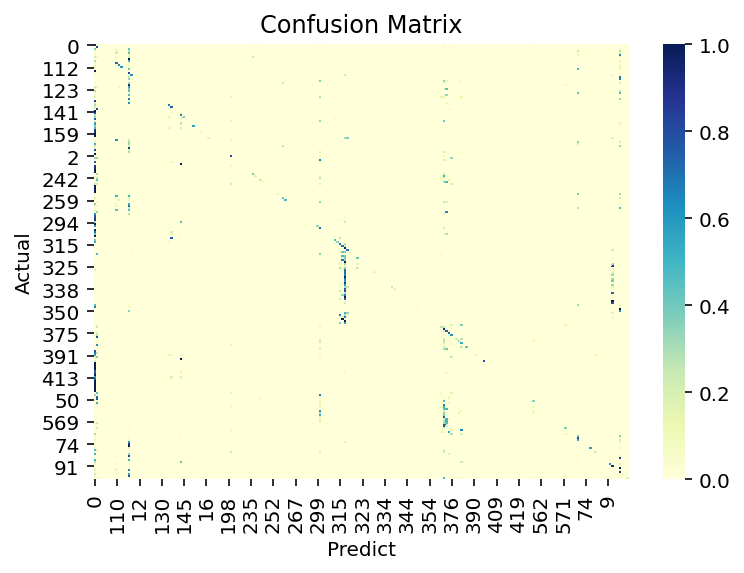

In [61]:
cm = ConfusionMatrix(actual_vector=categorical_train_labels, predict_vector=categorical_preds) # Create CM From Data
plot_confusion_matrix(cm,normalize=True,title="Confusion Matrix",annot=False)

In [79]:
path = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/cm_final.html'
cm.save_html(path, normalize=True)

{'Status': True,
 'Message': 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/cm_final.html.html'}

In [62]:
pred_cat = rfc.predict(df_test_meta.drop(dropped_features, axis=1))

count = 0
for i in range(len(pred_cat)):
    submission['Category'][count] = int(pred_cat[i])
    
    count += 1

In [63]:
submission.to_csv(DATA_DIR + 'submission_meta_009.csv', index=False)

In [97]:
def ordered_features(feature_importances, features, top=10, size=10):
    ordered = []
    importances = []
    
    while(len(ordered) < len(features)):
        max_fea = 0
        max_pos = 0
        for i in range(len(features)):
            if feature_importances[i] > max_fea and features[i] not in ordered:
                max_fea = feature_importances[i]
                max_pos = i
        ordered.append(features[max_pos])
        importances.append(max_fea)
    
    ordered.reverse()
    importances.reverse()
    
    fig = plt.figure()
    f, ax = plt.subplots(figsize=(size,size))
    ax.barh(ordered[len(ordered) - top:], importances[len(importances) - top:])
    ax.set_xlabel('Importance')
    ax.set_title('Top ' + str(top) + ' Feature Importances')
    plt.show()

<Figure size 432x288 with 0 Axes>

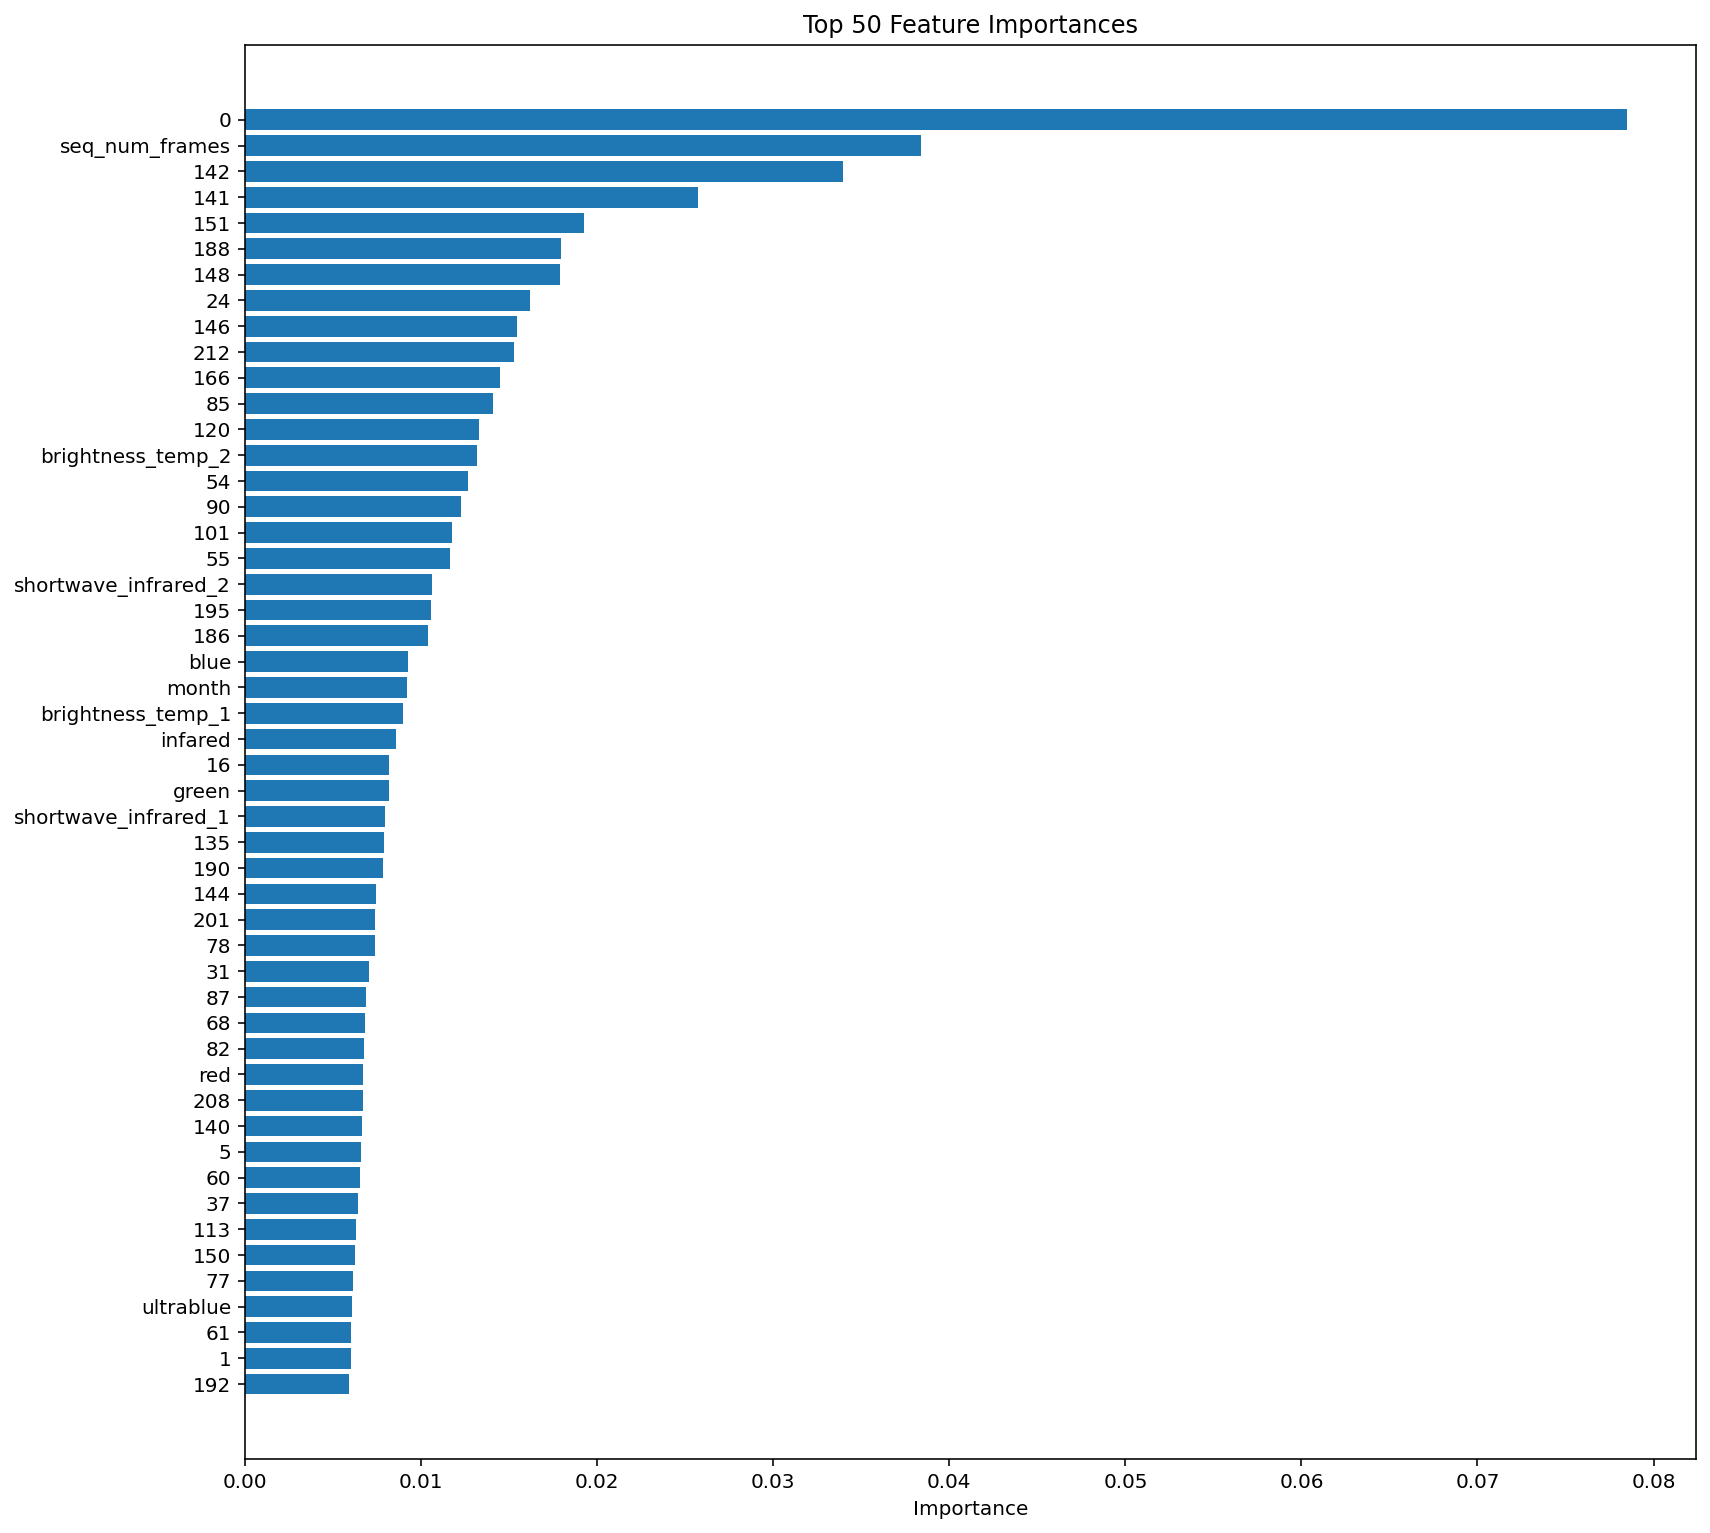

In [98]:
ordered_features(rfc.feature_importances_, df_train_meta.drop(dropped_features_train, axis=1).columns, top=50, size=13)

In [ ]:
misprediction columns 0, 115, 317, 3, 372, 96
115 - gunther's dik-dik - 8a1fdc78-21bc-11ea-a13a-137349068a90.jpg
317 - black-fronted duiker - 8a2f35d8-21bc-11ea-a13a-137349068a90.jpg
3 - central american agouti - 8a5e9634-21bc-11ea-a13a-137349068a90.jpg
372 - ocellated turkey - 8a0ade36-21bc-11ea-a13a-137349068a90.jpg
96 - impala - 8a0f84a4 - 21bc-11ea-a13a-137349068a90.jpg
374 - great curassow - 8a1a1d42-21bc-11ea-a13a-137349068a90.jpg

easily categorized columns 2, 404, 91, 139, 110, 112, 71
404 - misfire - 8a94eedc-21bc-11ea-a13a-137349068a90.jpg
110 - water buffalo - 8a25dc54-21bc-11ea-a13a-137349068a90.jpg
112 - girrafe - 8a0ab686-21bc-11ea-a13a-137349068a90.jpg
139 - great argus - 8c98a8ea-21bc-11ea-a13a-137349068a90.jpg
91 - giant pouched rat - 8a4a0048-21bc-11ea-a13a-137349068a90.jpg
2 - white-lipped peccary - 8a3b8bf8-21bc-11ea-a13a-137349068a90.jpg
71 - cow - 8a9ce22c-21bc-11ea-a13a-137349068a90.jpg

6, 100

In [96]:
pd.set_option('display.max_rows', 500)
df_train.sort_values('count', ascending=False)

count   id                       name
0    78981    0                      empty
36   33313   75                      human
188  16713  372         meleagris ocellata
189  12908  374                 crax rubra
146   9052  317     cephalophus nigrifrons
48    8517   96         aepyceros melampus
1     6355    2             tayassu pecari
2     5833    3        dasyprocta punctata
8     5824   10         leopardus pardalis
32    5118   71                 bos taurus
187   4542  371   urocyon cinereoargenteus
238   4477  647        dasyprocta leporina
4     4453    6              puma concolor
17    4099   24              panthera onca
195   3921  380              mazama temama
44    3614   90         loxodonta africana
191   3452  376            tapirus bairdii
65    3426  115          madoqua guentheri
223   3120  558                 motorcycle
190   2959  375                agouti paca
45    2630   91       cricetomys gambianus
39    2500   79                    unknown
61    2297  111               equus quagga
113   1937  243               didelphis sp
145   1849  316      cercopithecus lhoesti
105   1841  227          psophia crepitans
60    1755  110            syncerus caffer
62    1499  112     giraffa camelopardalis
111   1366  240               nasua narica
193   1343  378     odocoileus virginianus
144   1324  315        francolinus nobilis
194   1300  379      leptotila plumbeiceps
239   1291  648               crax alector
19    1284   26              tinamus major
6     1181    8              pecari tajacu
197   1119  384             mazama pandora
51    1099   99                equus ferus
122   1015  259               equus grevyi
79    1006  137          macaca nemestrina
147    973  318        atherurus africanus
66     915  116     potamochoerus larvatus
83     887  144          muntiacus muntjak
130    810  290             unidentifiable
150    787  321    funisciurus carruthersi
245    784  654          unknown armadillo
237    761  599       unknown mouse or rat
121    620  258       acryllium vulturinum
3      619    4             cuniculus paca
80     570  139           argusianus argus
38     562   78               papio anubis
119    545  256        camelus dromedarius
114    510  245      penelope purpurascens
243    508  652           myoprocta pratii
9      480   12          geotrygon montana
27     458   50           leopardus wiedii
55     449  103     phacochoerus africanus
250    393  659             tayassu tajacu
231    380  566                 sciurus sp
177    346  348                        end
49     338   97            crocuta crocuta
31     333   70             capra aegagrus
141    333  309   capricornis sumatraensis
7      330    9           mazama americana
142    330  310        macaca fascicularis
204    315  404                    misfire
100    300  179        leptotila rufaxilla
241    289  650            unknown opossum
148    287  319            pan troglodytes
12     260   15               eira barbara
87     254  152          hystrix brachyura
224    254  559              peromyscus sp
84     251  145                 sus scrofa
176    249  347                      start
53     248  101           tragelaphus oryx
246    245  655        mazama gouazaoubira
232    230  567            ave desconocida
157    223  328    cephalophus silvicultor
33     195   72                 ovis aries
233    195  568           aramides cajanea
18     187   25    myrmecophaga tridactyla
149    184  320        cercopithecus mitis
11     183   14       dasypus novemcinctus
14     167   17          penelope jacquacu
251    161  660             mitu tomentosa
54     160  102       kobus ellipsiprymnus
192    146  377              procyon lotor
226    130  561             unknown raptor
5      129    7         tapirus terrestris
85     128  147        helarctos malayanus
35     122   74            lepus saxatilis
198    120  385             ortalis vetula
230    120  565          claravis pretiosa
173   